In [27]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline
import numpy as np

# Quantum Circuit Born Machines

Unsupervised generative modelling emerges as a promising application for
achieving practical quantum advantage on classical data due to its high
complexity relative to supervised machine learning tasks. This makes
them a suitable candidate for leveraging the potential of near-term
quantum computers. A popular quantum generative model known as Quantum
Circuit Born Machines (QCBMs) has shown impressive results in modelling
distributions across various datasets, including both toy and real-world
datasets, and you will learn about them in this demo.

![](https://blog-assets.cloud.pennylane.ai/demos/tutorial_qcbm/main/_assets/static/demo_thumbnails/opengraph_demo_thumbnails/OGthumbnail_large_QuantumCircuitBornMachines_2024-05-13.png)

Generative modelling with QCBMs \-\-\-\-\-\-\-\-\-\-\-\--

Quantum Circuit Born machines (QCBMs) show promise in unsupervised
generative modelling, aiming to learn and represent classical dataset
probability distributions through pure quantum states. They are popular
due to their high expressive power. Born machines leverage the
probabilistic interpretation of quantum wavefunctions, representing
probability distributions with pure quantum states instead of thermal
distributions like Boltzmann machines. This allows Born machines to
directly generate samples through projective measurements on qubits,
offering a faster alternative to the Gibbs sampling approach.

For a dataset $\mathcal{D} = \{x\}$ with independent and identically
distributed samples from an unknown target distribution $\pi(x),$ QCBM
is used to generate samples closely resembling the target distribution.
QCBM transforms the input product state $|\mathbf{0} \rangle$ to a
parameterized quantum state $|\psi_{\boldsymbol{\theta}}\rangle.$
Measuring this output state in the computational basis yields a sample
of bits $x \sim p_\theta(x).$

$$p_{\boldsymbol{\theta}}(x) = |\langle x | \psi_{\boldsymbol{\theta}} \rangle|^2.$$

The objective is to align the model probability distribution
$p_{\boldsymbol{\theta}}$ with the target distribution $\pi.$

In this tutorial, following, we will implement a gradient-based
algorithm for QCBM using PennyLane. We describe the model and learning
algorithm followed by its application to the $3 \times 3$ Bars and
Stripes dataset and double Gaussian peaks.

To train the QCBM, we use the squared maximum mean discrepancy (MMD) as
the loss function

$$\mathcal{L}(\boldsymbol{\theta}) = \left\|\sum_{x} p_{\boldsymbol{\theta}}(x) \phi(x)- \sum_{x} \pi(x) \phi(x)  \right\|^2,$$

where $\phi(x)$ maps $x$ to a larger feature space. Using a kernel
$K(x,y) = \phi(x)^T\phi(y)$ allows us to work in a lower-dimensional
space. We use the Radial basis function (RBF) kernel for this purpose,
which is defined as:

$$K(x,y) = \frac{1}{c}\sum_{i=1}^c \exp \left( \frac{|x-y|^2}{2\sigma_i^2} \right).$$

Here, $\sigma_i$ is the bandwidth parameter controlling the Gaussian
kernel\'s width. $\mathcal{L}$ approaches to zero if and only if
$p_{\boldsymbol{\theta}}$ approaches $\pi$. To learn more about kernel
methods, check out this
[demo](https://pennylane.ai/qml/demos/tutorial_kernels_module).

We can now write the loss function in terms of $K(x,y)$ as

$$\mathcal{L} = \underset{x, y \sim p_{\boldsymbol{\theta}}}{\mathbb{E}}[{K(x,y)}]-2\underset{x\sim p_{\boldsymbol{\theta}},y\sim \pi}{\mathbb{E}}[K(x,y)]+\underset{x, y \sim \pi}{\mathbb{E}}[K(x, y)]$$


Armed with these ingredients, we can write code for the QCBM and the
loss function. We first define the `MMD` class for computing the squared
MMD loss with radial basis function kernel. Upon initialization, it
calculates the kernel function.


In [28]:
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)


class MMD:

    def __init__(self, scales, space):
        gammas = 1 / (2 * (scales**2))
        sq_dists = jnp.abs(space[:, None] - space[None, :]) ** 2
        self.K = sum(jnp.exp(-gamma * sq_dists) for gamma in gammas) / len(scales)
        self.scales = scales

    def k_expval(self, px, py):
        # Kernel expectation value
        return px @ self.K @ py

    def __call__(self, px, py):
        pxy = px - py
        return self.k_expval(pxy, pxy)

Defining classes helps in caching the kernel instead of calculating it
everytime to find the expectation value. Next up, the `QCBM` holds the
definition for the quantum circuit born machine and the objective
function to minimize.


In [29]:
from functools import partial


class QCBM:

    def __init__(self, circ, mmd, py):
        self.circ = circ
        self.mmd = mmd
        self.py = py  # target distribution π(x)

    @partial(jax.jit, static_argnums=0)
    def mmd_loss(self, params):
        px = self.circ(params)
        return self.mmd(px, self.py), px

## Discretization: From Continuous to Discrete

**Key Challenge**: QCBM works with discrete bitstrings, but hadron momenta are continuous.

**Solution**: Discretize using histograms:
1. Choose n_qubits (e.g., 6 qubits → 64 bins)
2. Create histogram of continuous data
3. Each bin becomes a computational basis state |x⟩
4. Target distribution π(x) = normalized histogram counts

In [30]:
import pandas as pd
import numpy as np

# Load hadron collision data
df = pd.read_csv('first_emission_50gev.csv')

print(f"Loaded {len(df)} hadron events")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())

# Extract momentum data
pT_data = df['Particle_pT'].values
pz_data = df['Particle_pz'].values
E_data = df['Particle_E'].values

# Calculate rescaled longitudinal momentum pz'
# pz' = E_ref * (pz / E) normalizes by energy
E_ref = 50.0  # Reference energy in GeV
pz_prime = E_ref * (pz_data / E_data)

print(f"\nData statistics:")
print(f"  pT range: [{pT_data.min():.3f}, {pT_data.max():.3f}] GeV/c")
print(f"  pz range: [{pz_data.min():.3f}, {pz_data.max():.3f}] GeV/c")
print(f"  pz' range: [{pz_prime.min():.3f}, {pz_prime.max():.3f}] GeV/c")

Loaded 10000 hadron events
Columns: ['Event', 'Name', 'Pid', 'Particle_px', 'Particle_py', 'Particle_pz', 'Particle_E', 'Particle_pT']

First few rows:
   Event Name  Pid  Particle_px  Particle_py  Particle_pz  Particle_E  \
0      0  pi0  111     0.160985     0.235890    36.980500   36.981800   
1      1  pi0  111     0.236153     0.365678    22.802300   22.806800   
2      2  pi- -211     0.072274     0.046684     0.632455    0.653362   
3      3  pi- -211     0.036291     0.250416    41.818200   41.819200   
4      4  pi0  111    -0.149215     0.046229     8.431800    8.434330   

   Particle_pT  
0     0.285588  
1     0.435303  
2     0.086040  
3     0.253032  
4     0.156212  

Data statistics:
  pT range: [0.002, 1.706] GeV/c
  pz range: [0.254, 49.526] GeV/c
  pz' range: [42.608, 50.000] GeV/c


In [31]:
# Discretization function
def discretize_to_target_distribution(continuous_data, n_qubits):
    """
    Convert continuous data to discrete probability distribution for QCBM.
    
    Args:
        continuous_data: Array of continuous values
        n_qubits: Number of qubits (determines n_bins = 2^n_qubits)
    
    Returns:
        probs: Probability distribution π(x) over 2^n_qubits states
        bin_edges: Histogram bin edges for reference
    """
    n_bins = 2 ** n_qubits
    
    # Create histogram
    counts, bin_edges = np.histogram(continuous_data, bins=n_bins)
    
    # Normalize to probability distribution
    probs = counts / counts.sum()
    
    print(f"Discretization with {n_qubits} qubits → {n_bins} bins")
    print(f"  Non-zero bins: {np.count_nonzero(probs)}/{n_bins}")
    print(f"  Max probability: {probs.max():.4f}")
    print(f"  Entropy: {-np.sum(probs[probs > 0] * np.log(probs[probs > 0])):.4f}")
    
    return probs, bin_edges

# Example: Discretize pT distribution
n_qubits = 6  # 64 bins - good balance for ~10k samples
pT_target_probs, pT_bins = discretize_to_target_distribution(pT_data, n_qubits)

# Example: Discretize pz' distribution  
pz_target_probs, pz_bins = discretize_to_target_distribution(pz_prime, n_qubits)

# This is our data array - analogous to the Bars & Stripes "data" variable
# but represented as a probability distribution
size = n_qubits  # Number of qubits
data = pT_target_probs  # CHANGE THIS TO TRAIN ON PZ' DISTRIBUTION
probs = data  # Target distribution π(x)

Discretization with 6 qubits → 64 bins
  Non-zero bins: 44/64
  Max probability: 0.0672
  Entropy: 3.1510
Discretization with 6 qubits → 64 bins
  Non-zero bins: 35/64
  Max probability: 0.8449
  Entropy: 0.7214


# ***\*\*\*CHANGE THE CODE ABOVE TO CHANGE TRAINING FROM PT TO PZ' DISTRIBUTION\*\*\****
and also change the variables in the testing section

# Hadron Data Loading and Preprocessing

In [32]:
import pennylane as qml

np.random.seed(42)


n_qubits = size
dev = qml.device("default.qubit", wires=n_qubits)

n_layers = 6
wshape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
weights = np.random.random(size=wshape)


@qml.qnode(dev)
def circuit(weights):
    qml.StronglyEntanglingLayers(weights=weights, ranges=[1] * n_layers, wires=range(n_qubits))
    return qml.probs()


jit_circuit = jax.jit(circuit)

Using the `MMD` and `QCBM` classes defined earlier, we create their
respective objects. Using Optax, we define the Adam optimizer.


In [33]:
import optax

bandwidth = jnp.array([0.25, 0.5, 1])
space = jnp.arange(2**n_qubits)

mmd = MMD(bandwidth, space)
qcbm = QCBM(jit_circuit, mmd, probs)

opt = optax.adam(learning_rate=0.1)
opt_state = opt.init(weights)

We can also verify that the summation in the first line of $\mathcal{L}$
is equal to the expectation values in the second line.


In [34]:
loss_1, px = qcbm.mmd_loss(weights)  # squared MMD
loss_2 = mmd.k_expval(px, px) - 2 * mmd.k_expval(px, probs) + mmd.k_expval(probs, probs)
print(loss_1)
print(loss_2)

0.10236768474561546
0.10236768474561547


# Training

We define the `update_step` method which

-   computes the squared MMD loss and gradients.
-   apply the update step of our optimizer.
-   updates the parameter values.
-   calculates the KL divergence.

The KL divergence is a measure of how far the predicted distribution
$p_{\boldsymbol{\theta}}(x)$ is from the target distribution $\pi(x).$


In [35]:
@jax.jit
def update_step(params, opt_state):
    (loss_val, qcbm_probs), grads = jax.value_and_grad(qcbm.mmd_loss, has_aux=True)(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

    log_ratio = jnp.where(qcbm.py == 0, 0, jnp.log(qcbm_probs / qcbm.py))

    kl_div = -jnp.sum(qcbm.py *  log_ratio)
    return params, opt_state, loss_val, kl_div


history = []
divs = []
n_iterations = 100

for i in range(n_iterations):
    weights, opt_state, loss_val, kl_div = update_step(weights, opt_state)

    if i % 10 == 0:
        print(f"Step: {i} Loss: {loss_val:.4f} KL-div: {kl_div:.4f}")

    history.append(loss_val)
    divs.append(kl_div)

Step: 0 Loss: 0.1024 KL-div: 1.9954
Step: 10 Loss: 0.0123 KL-div: 0.3619
Step: 20 Loss: 0.0036 KL-div: 0.1796
Step: 30 Loss: 0.0012 KL-div: 0.0857
Step: 40 Loss: 0.0004 KL-div: 0.0598
Step: 50 Loss: 0.0002 KL-div: 0.0496
Step: 60 Loss: 0.0001 KL-div: 0.0335
Step: 70 Loss: 0.0001 KL-div: 0.0279
Step: 80 Loss: 0.0001 KL-div: 0.0212
Step: 90 Loss: 0.0001 KL-div: 0.0199


Visualizing the training results, we get the following plot.


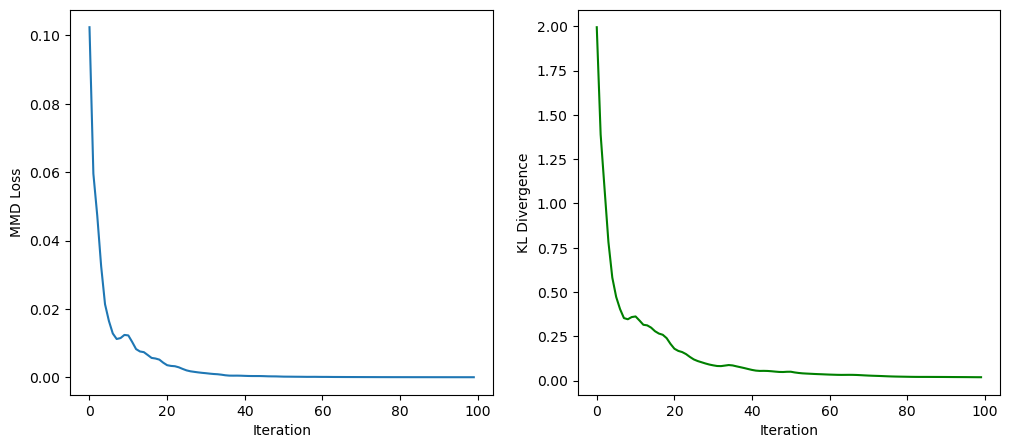

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(history)
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("MMD Loss")

ax[1].plot(divs, color="green")
ax[1].set_xlabel("Iteration")
ax[1].set_ylabel("KL Divergence")
plt.show()

Comparing the target probability distribution with the QCBM predictions,
we can see that the predictions results in a good approximation.


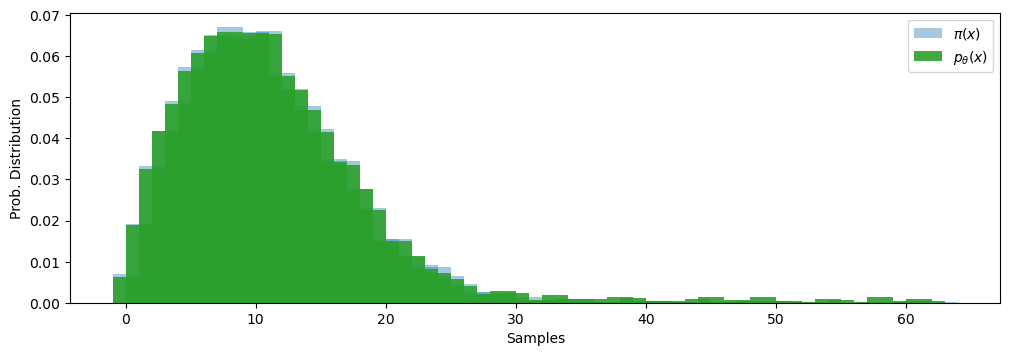

In [37]:
qcbm_probs = np.array(qcbm.circ(weights))

plt.figure(figsize=(12, 5))

plt.bar(
    np.arange(2**size),
    probs,
    width=2.0,
    label=r"$\pi(x)$",
    alpha=0.4,
    color="tab:blue",
)
plt.bar(
    np.arange(2**size),
    qcbm_probs,
    width=2.0,
    label=r"$p_\theta(x)$",
    alpha=0.9,
    color="tab:green",
)

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")

# plt.xticks(nums, bitstrings, rotation=80)
plt.legend(loc="upper right")
plt.subplots_adjust(bottom=0.3)
plt.show()

# Testing

To visualize the performance of the model, we generate samples and
compute $\chi \equiv$ P($x$ is a bar or stripe) which is a measure of
generation quality.


In [38]:
# Create sampling device and circuit
sampling_dev = qml.device("default.qubit", wires=n_qubits, shots=1000)

@qml.qnode(sampling_dev)
def sample_circuit(weights):
    qml.StronglyEntanglingLayers(weights=weights, ranges=[1]*n_layers, wires=range(n_qubits))
    return qml.sample()

# Generate samples (returns array of measurement outcomes)
samples = sample_circuit(weights)

# Convert samples from bitstrings to bin indices
bin_indices = np.array([int(''.join(str(b) for b in sample), 2) for sample in samples])

# Map bin indices to momentum values
generated_pT = np.array([(pT_bins[i] + pT_bins[i+1])/2 for i in bin_indices if i < len(pT_bins)-1])

print(f"Generated {len(generated_pT)} hadron events")
print(f"Sample bin indices: {bin_indices[:10]}")
print(f"Sample pT values: {generated_pT[:10]}")


Generated 1000 hadron events
Sample bin indices: [16  5  8 14 20  8 11  7  5  2]
Sample pT values: [0.44169156 0.1488395  0.22870824 0.38844573 0.54818322 0.22870824
 0.30857699 0.20208533 0.1488395  0.06897076]


Few of the samples are plotted below. The ones with a red border
represents invalid images.


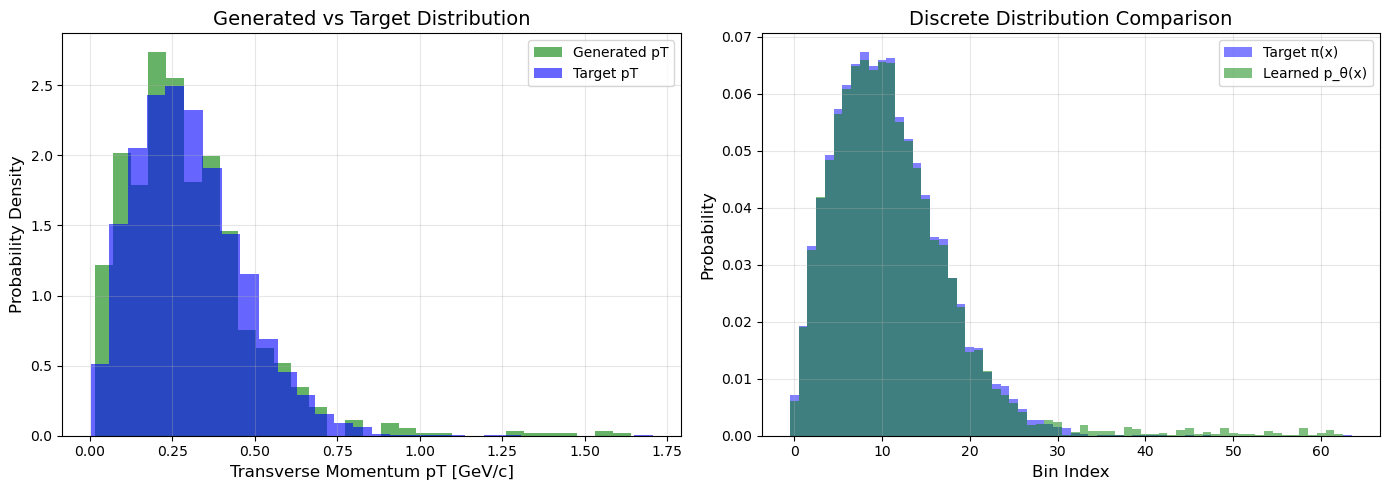


KL Divergence (final): 0.0186
MMD Loss (final): 0.0000


In [39]:
# Plot generated distribution vs target
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Histogram comparison
axes[0].hist(generated_pT, bins=30, density=True, alpha=0.6, label='Generated pT', color='green')
axes[0].hist(pT_data, bins=30, density=True, alpha=0.6, label='Target pT', color='blue') # <- change from pT_data to pz_prime
axes[0].set_xlabel('Transverse Momentum pT [GeV/c]', fontsize=12)
axes[0].set_ylabel('Probability Density', fontsize=12)
axes[0].set_title('Generated vs Target Distribution', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Right: Discrete probability comparison
axes[1].bar(np.arange(2**size), pT_target_probs, width=1.0, alpha=0.5, label='Target π(x)', color='blue') # <- change from pT_target_probs to pz_target_probs
axes[1].bar(np.arange(2**size), qcbm_probs, width=1.0, alpha=0.5, label='Learned p_θ(x)', color='green')
axes[1].set_xlabel('Bin Index', fontsize=12)
axes[1].set_ylabel('Probability', fontsize=12)
axes[1].set_title('Discrete Distribution Comparison', fontsize=14)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nKL Divergence (final): {kl_div:.4f}")
print(f"MMD Loss (final): {loss_val:.4f}")


The model is able to learn the target distribution due to a circuit with
larger layers. Also, has argued that training a QCBM with deeper
circuits does not suffer from the vanishing gradients problem.
